In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import custom_model
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import shuffle
import numpy as np
import itertools, os
from tqdm import tqdm

2024-02-06 09:09:24.181287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model_name = 'enformer'
csv_dir = f'../results/summary_csvs/{model_name}/'
sufficient_cre_df = pd.read_csv(f'{csv_dir}/sufficient_CREs.csv')
pdf_dir = utils.make_dir('pdfs/multiplicity/')

In [6]:
sufficient_cre_df.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  (MUT - CONTROL) / WT   
cell_line tile class context                                       
GM12878   Enhancer   enhancing          41                    41  \
          Silencer   silencing          57                    57   
K562      Enhancer   enhancing          74                    74   
          Silencer   silencing         222                   222   
PC-3      Enhancer   enhancing          35                    35   
          Silencer   silencing          97                    97   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         41      41       41  \
          Silencer   silencing                         57      57       57   
K562      Enhancer   enhancing                         74      74       74   
          Silencer   silencing                        222     222      222   
PC-3      Enhancer   enhancing                         35      35       35   
          Silencer   silencing                         97      97       97   

                                 wt  mut  tile_start  tile_end   
cell_line tile class context                                     
GM12878   Enhancer   enhancing   41   41          41        41  \
          Silencer   silencing   57   57          57        57   
K562      Enhancer   enhancing   74   74          74        74   
          Silencer   silencing  222  222         222       222   
PC-3      Enhancer   enhancing   35   35          35        35   
          Silencer   silencing   97   97          97        97   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     41  
          Silencer   silencing                     57  
K562      Enhancer   enhancing                     74  
          Silencer   silencing                    222  
PC-3      Enhancer   enhancing                     35  
          Silencer   silencing                     97

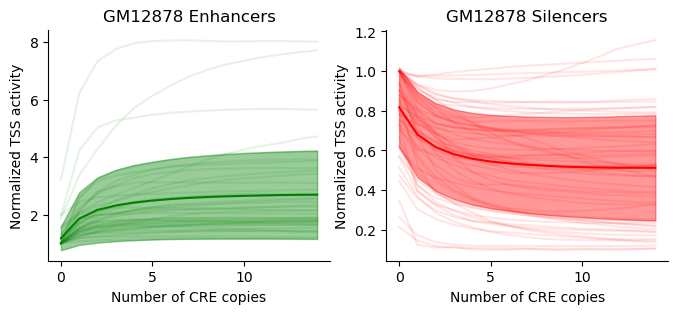

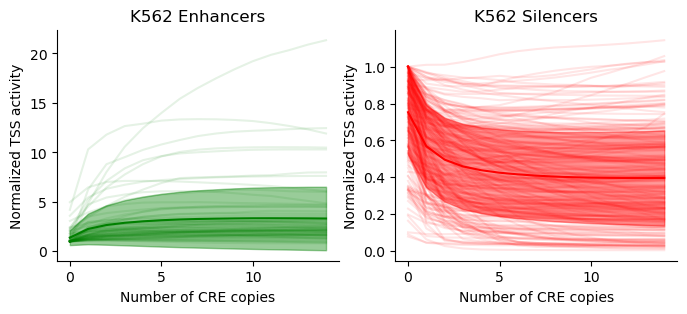

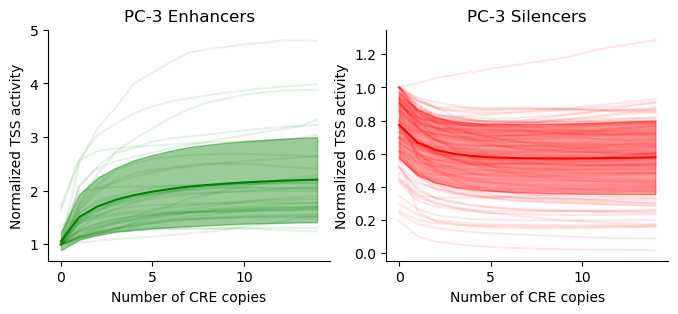

In [7]:
for cell, cell_df in sufficient_cre_df.groupby('cell_line'):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    for tile_type, df in cell_df.groupby('tile class'):

        tss_activity = []
        if tile_type == 'Enhancer':
            c = 'g'
            ax = axes[0]
        else:
            c = 'r'
            ax = axes[1]
        for i, row in df.iterrows():
            result_path = f'../results/multiplicity_test/{model_name}/{cell}/{row["seq_id"]}_tile_start_{row["tile_start"]}_tile_end_{row["tile_end"]}.pickle'
            # assert os.path.isfile(result_path), f'File {result_path} not found'
            res = utils.read_pickle(result_path)
            v = np.array(res['best_tss_signal']) / res['tss_and_cre_pred'] # normalize by original CRE position 
            ax.plot(v, alpha=0.1, color=c)
            tss_activity.append(v)
        mean_tss = np.array(tss_activity).mean(axis=0)
        std_tss = np.array(tss_activity).std(axis=0)

        ax.plot(mean_tss, color=c)
        ax.fill_between(range(mean_tss.shape[0]), mean_tss-std_tss, mean_tss+std_tss, color=c, alpha=0.4)
        # plt.ylim(0, 4)
        ax.set_title(f'{cell} {tile_type}s')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Number of CRE copies', fontsize=10)
        ax.set_ylabel('Normalized TSS activity', fontsize=10)
    fig.savefig(f'{pdf_dir}/{cell}_enhancers_silencers.pdf')



(15,)